In [21]:
import torch
import jaxtyping
import tqdm
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available()
                    #   else "mps" if torch.backends.mps.is_available()
                      else "cpu")

# Number of features (aka d0 as we're not doing superposition input)
m = 100

# Feature sparsity
k = 3

# Hidden dims
d = 1000

# Relative importance of non-zero outputs
alpha = 100


class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(m, d)
        self.relu = torch.nn.ReLU()
        # self.relu = torch.nn.LeakyReLU(0.1)
        self.linear2 = torch.nn.Linear(d, m**2)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [22]:
def random_sparse_inputs(batch_size):
    x = torch.zeros(batch_size, m, device=device)

    # For each item in batch, randomly select k indices to set to 1
    # for i in range(batch_size):
    #     # Get k random indices between 0 and m-1
    #     indices = torch.randperm(m)[:k]
    #     x[i, indices] = 1

    indices = torch.multinomial(torch.ones(batch_size, m, device=device), k, replacement=False)
    x.scatter_(1, indices, 1)
    return x

def first_inputs():
    x = torch.zeros(1, m, device=device)
    x[0, :k] = 1
    return x

def random_first_inputs(batch_size, first=[1,1]):
    first = torch.tensor(first, device=device)
    first_len = first.shape[0]
    first_count = first.sum()
    x = torch.zeros(batch_size, m, device=device)
    indices = torch.multinomial(torch.ones(batch_size, m-first_len, device=device), k-first_count, replacement=False)
    x.scatter_(1, indices+first_len, 1)
    x[:, :first_len] = first[None, :]
    return x

def compute_expected(inputs):
    batch_size = inputs.shape[0]
    y = torch.zeros(batch_size, m, m, device=device)
    y = inputs[:, None, :] * inputs[:, :, None]
    y[:, range(m), range(m)] = 0
    y = y.view(batch_size, m**2)
    return y


def weighted_loss(outputs, targets):
    err = (outputs - targets)**2 
    err = err * (1 + targets * (alpha - 1))
    return err.mean()


In [47]:
model = MyModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
# Force all positive intializer
#model.linear.weight.data = torch.abs(model.linear.weight.data)


In [50]:

def train_model(model, batch_size=10000, n_epochs=3000, optimizer=optimizer, criterion=weighted_loss):
    criterion = weighted_loss

    progress_bar = tqdm.tqdm(range(n_epochs))
    for epoch in progress_bar:
        # Generate random batch of sparse inputs
        inputs = random_sparse_inputs(batch_size)
        
        # Compute expected outputs
        targets = compute_expected(inputs)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        progress_bar.set_description(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.6f}')

train_model(model, n_epochs=3000)


Epoch [328/3000], Loss: 0.011140:  11%|█         | 328/3000 [01:33<17:51,  2.49it/s]

In [71]:
# Save model checkpoint
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'model_checkpoint.pth')


In [45]:
# Load model checkpoint
checkpoint = torch.load('model_checkpoint_relu_a100_weightdecay.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [39]:
# Construct model
import math
def construct_model(p=None, randomize=False):
    p = math.log(m)**2/math.sqrt(d) if p is None else p
    # expected_intersection = p*p*d
    # expected_false_positives = (k-1)*p
    # print(f"{p=}")
    # print(f"{expected_intersection=} {expected_false_positives=}")
    model = MyModel()
    model.linear.weight.data = (torch.rand(d, m, device=device) < p).float()
    model.linear.bias.data = -torch.ones(d, device=device)
    model.linear2.bias.data = torch.zeros(m**2, device=device)
    weights2 = torch.zeros(m, m, d, device=device)
    l = model.linear.weight.data
    for i in range(m):
        for j in range(m):
            if i == j:
                continue
            # find intersecting set
            s = l[:, i] * l[:, j]
            ssum = s.sum()
            weights2[i, j, :] =  s / ssum if ssum > 0 else torch.zeros_like(s, device=device)
    model.linear2.weight.data = weights2.reshape(m**2, d)

    if randomize:
        rnd_scale = 0.01
        model.linear2.weight.data += torch.randn(m**2, d, device=device) * rnd_scale
        model.linear2.bias.data += torch.randn(m**2, device=device) * rnd_scale
        model.linear.weight.data += torch.randn(d, m, device=device) * rnd_scale
        model.linear.bias.data += torch.randn(d, device=device) * rnd_scale
    return model
model = construct_model(0.1, randomize=True)



Test Loss: 0.011291
tensor([[ 5.3956e-10,  7.2830e-01,  7.6055e-01,  3.8420e-01,  3.7639e-01,
          3.5209e-01,  3.6629e-01,  3.6875e-01,  3.6073e-01],
        [ 7.2830e-01, -2.5671e-07,  7.7370e-01,  3.7422e-01,  3.6519e-01,
          3.7981e-01,  3.5843e-01,  3.4663e-01,  3.5820e-01],
        [ 7.6055e-01,  7.7370e-01, -6.3454e-15,  3.6332e-01,  3.5319e-01,
          3.6257e-01,  3.5859e-01,  3.7826e-01,  3.9186e-01],
        [ 3.8420e-01,  3.7422e-01,  3.6332e-01,  1.3254e-04,  1.2895e-02,
         -1.0926e-02, -1.9325e-02,  6.5783e-03, -2.1186e-02],
        [ 3.7639e-01,  3.6519e-01,  3.5319e-01,  1.2895e-02, -2.6978e-05,
         -1.1806e-02, -2.6825e-02, -1.0382e-02,  1.2182e-02],
        [ 3.5209e-01,  3.7981e-01,  3.6257e-01, -1.0926e-02, -1.1806e-02,
          4.6297e-05, -1.9349e-02,  8.5416e-04, -1.8163e-02],
        [ 3.6629e-01,  3.5843e-01,  3.5859e-01, -1.9325e-02, -2.6824e-02,
         -1.9349e-02, -5.6054e-15,  4.0816e-03, -4.8695e-03],
        [ 3.6875e-01,  3.46

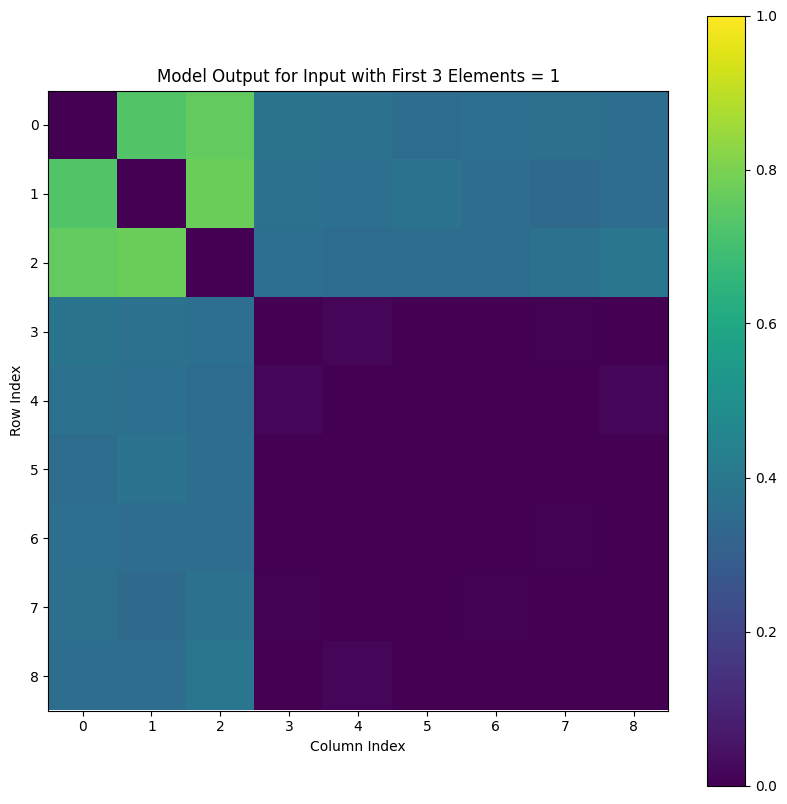

In [46]:

# Test the model
def test_model(model):
    with torch.no_grad():
        test_inputs = random_sparse_inputs(1000)
        test_outputs = model(test_inputs)
        expected_outputs = compute_expected(test_inputs)
        test_loss = weighted_loss(test_outputs, expected_outputs)
        return test_loss
    
# Compute the loss
test_loss = test_model(model)
print(f'\nTest Loss: {test_loss.item():.6f}')

def plot_output(model):
# See the output for a particular input
    with torch.no_grad():
        test_input = first_inputs()
        test_output = model(test_input)
    k2 = k * 3
    test_output_mini = test_output[0].reshape(m, m)[:k2, :k2]
    print(test_output_mini)
    # Visualize the test output as a heatmap, with values normalized between 0 and 1
    plt.figure(figsize=(10, 10))
    plt.imshow(test_output_mini.cpu().numpy(), cmap='viridis')
    plt.clim(0, 1)
    plt.colorbar()
    plt.title(f'Model Output for Input with First {k} Elements = 1')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

plot_output(model)

100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


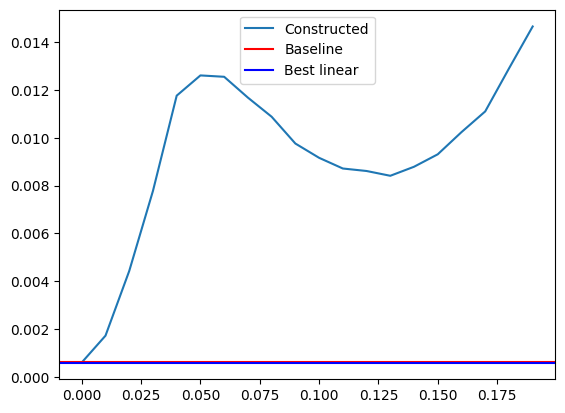

In [112]:
# Loss from a model that just outputs 0
baseline = k*(k-1)/m/m
# Loss from a model that can solve an arbitrary 2m of the m*m outputs
best_linear=(k*(k-1))/m/m * (m*m - 2*m)/m/m

# Plot loss of constructed model for different p
x = []
y = []
for p in tqdm.tqdm(torch.arange(0, 0.2, 0.01)):
    p_model = construct_model(p)
    p_test_loss = test_model(p_model)
    # print(f"{p=} {p_test_loss=}")
    x.append(p)
    y.append(p_test_loss)
plt.plot(x, y, label='Constructed')
plt.axhline(baseline, color='red', label='Baseline')
plt.axhline(best_linear, color='blue', label='Best linear')
plt.legend()
plt.show()


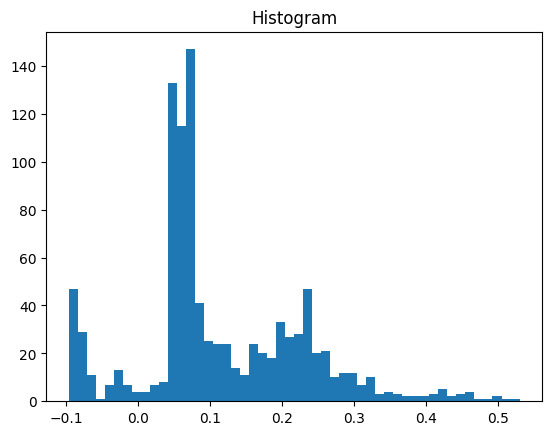

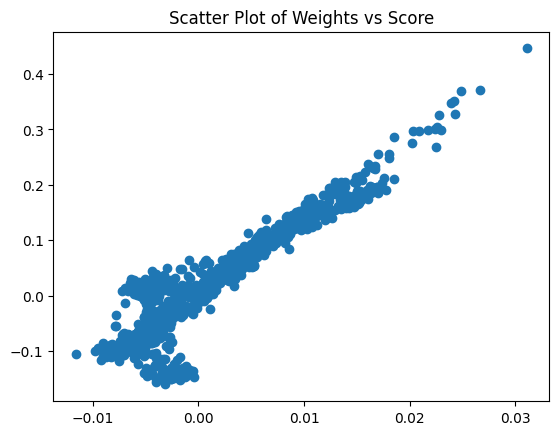

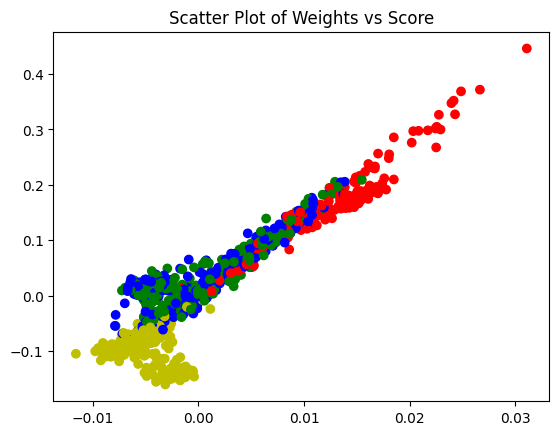

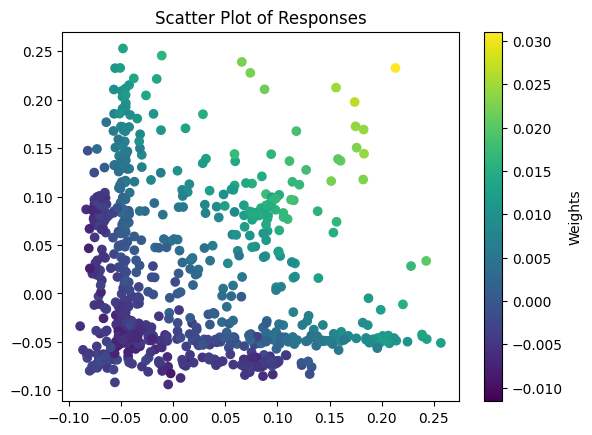

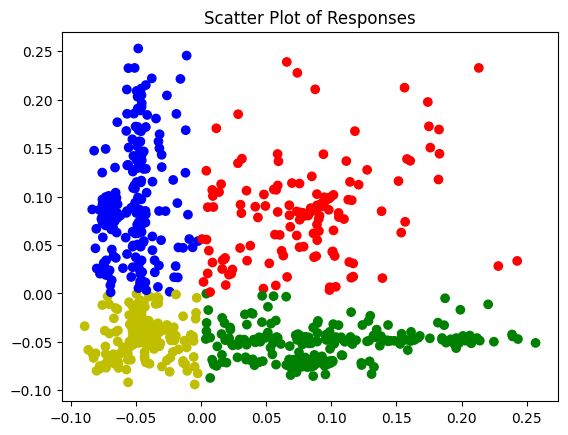

In [52]:
import numpy as np


weights = model.linear2.weight[1]

with torch.no_grad():
    # Pre-relu intermidiate values under different asusmpts of the inputs
    ints_00 = model.linear(random_first_inputs(10000, [0, 0])).mean(dim=0, keepdim=True)
    ints_01 = model.linear(random_first_inputs(10000, [0, 1])).mean(dim=0, keepdim=True)
    ints_10 = model.linear(random_first_inputs(10000, [1, 0])).mean(dim=0, keepdim=True)
    ints_11 = model.linear(random_first_inputs(10000, [1, 1])).mean(dim=0, keepdim=True)


v0 = 9
v1 = 10

# How does each itnermediate value respond to each input?
resp0 = model.linear.weight[None, :, v0]
resp1 = model.linear.weight[None, :, v1]

weights = model.linear2.weight[v1*m + v0]

# Color from quadrant
colors = np.where((resp0.detach().cpu().numpy() >= 0) & (resp1[0].detach().cpu().numpy() >= 0), 'r', 
         np.where((resp0.detach().cpu().numpy() >= 0) & (resp1[0].detach().cpu().numpy() < 0), 'g', 
         np.where((resp0.detach().cpu().numpy() < 0) & (resp1[0].detach().cpu().numpy() >= 0), 'b', 'y')))[0]

# Color from angle
# angle = np.arctan2(resp1[0].detach().cpu().numpy(), resp0[0].detach().cpu().numpy())
# colors = np.mod(angle, 2*np.pi) / (2*np.pi)



# colors = []
# for r1, r2 in zip(resp0[0].detach().cpu().numpy(), resp1[0].detach().cpu().numpy()):
#     top = 0.15
#     bottom = -0.08
#     r3 = (r1 + r2) / 2
#     r1 = max(min((r1 - bottom) / (top - bottom), 1), 0)
#     r2 = max(min((r2 - bottom) / (top - bottom), 1), 0)
#     r3 = max(min((r3 - bottom) / (top - bottom), 1), 0)
#     colors.append((r1, r2, r3))

wc = weights.detach().cpu().numpy()

score = resp0 + resp1

plt.hist(ints_11[0].detach().cpu().numpy(), bins=50)
plt.title('Histogram')
plt.show()

plt.scatter(weights.detach().cpu().numpy(), score[0].detach().cpu().numpy())
plt.title('Scatter Plot of Weights vs Score')
plt.show()
plt.scatter(weights.detach().cpu().numpy(), score[0].detach().cpu().numpy(), c=colors)
plt.title('Scatter Plot of Weights vs Score')
plt.show()



plt.scatter(resp0.detach().cpu().numpy(), resp1[0].detach().cpu().numpy(), c=wc)
plt.colorbar(label='Weights')
plt.title('Scatter Plot of Responses')
plt.show()
plt.scatter(resp0.detach().cpu().numpy(), resp1[0].detach().cpu().numpy(), c=colors)
plt.title('Scatter Plot of Responses')
plt.show()








In [17]:
mask = (resp0[0] < -0.1) & (resp1[0] < -0.1)
#mask = (resp0[0] > 0.01) & (resp1[0] > 0.01)


for r0, r1, w, m in sorted(zip(resp0[0], resp1[0], weights, mask), key=lambda x: -x[2].item()):
    if m:
        print(f"{r0.item():10.4f}, {r1.item():10.4f}, {w.item():10.4f}")


   -0.1754,    -0.1755,     0.0117
   -0.1517,    -0.1518,     0.0116
   -0.1575,    -0.1573,     0.0111
